# Mejoras en Inferencia de Batches: Reducción de Sobreestimación y Artefactos en Predicciones Globales

En este test, realizamos predicciones utilizando el modelo Aurora preentrenado, enfocándonos en mejorar la inferencia de batches para reducir la sobreestimación de la temperatura y minimizar los artefactos (como cuadrículas visibles) en las predicciones globales.

## Instalación de Dependencias

Antes de comenzar, asegúrate de instalar los paquetes necesarios:

```bash
pip install requests xarray cfgrib scipy matplotlib


In [1]:
from datetime import datetime
from pathlib import Path
import requests
import xarray as xr
import numpy as np
import torch
from aurora import Batch, Metadata, AuroraHighRes, rollout
import matplotlib.pyplot as plt

c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Descarga de Datos

Descargamos datos de análisis HRES a 0.1 grados de resolución para el día 11 de mayo de 2022 desde el Research Data Archive. Estos datos incluyen variables atmosféricas y de superficie necesarias para el modelo Aurora.


In [2]:
# Ruta de descarga y fecha
download_path = Path("~/downloads/hres_0.1").expanduser()
date = datetime(2022, 5, 11)

# Variables y sus códigos para la solicitud
var_nums = {
    "2t": "167",    # Temperatura a 2 metros
    "10u": "165",   # Componente u del viento a 10 metros
    "10v": "166",   # Componente v del viento a 10 metros
    "msl": "151",   # Presión media a nivel del mar
    "t": "130",     # Temperatura (atmosférica)
    "u": "131",     # Componente u del viento (atmosférica)
    "v": "132",     # Componente v del viento (atmosférica)
    "q": "133",     # Humedad específica (atmosférica)
    "z": "129",     # Geopotencial
    "slt": "043",   # Tipo de suelo
    "lsm": "172",   # Máscara tierra-mar
}

# Construcción de URLs para descargar los datos
downloads: dict[Path, str] = {}
for v in ["2t", "10u", "10v", "msl", "z", "slt", "lsm"]:
    downloads[download_path / date.strftime(f"surf_{v}_%Y-%m-%d.grib")] = (
        f"https://data.rda.ucar.edu/ds113.1/"
        f"ec.oper.an.sfc/{date.year}{date.month:02d}/ec.oper.an.sfc.128_{var_nums[v]}_{v}."
        f"regn1280sc.{date.year}{date.month:02d}{date.day:02d}.grb"
    )
for v in ["z", "t", "u", "v", "q"]:
    for hour in [0, 6, 12, 18]:
        prefix = "uv" if v in {"u", "v"} else "sc"
        downloads[download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_{hour:02d}.grib")] = (
            f"https://data.rda.ucar.edu/ds113.1/"
            f"ec.oper.an.pl/{date.year}{date.month:02d}/ec.oper.an.pl.128_{var_nums[v]}_{v}."
            f"regn1280{prefix}.{date.year}{date.month:02d}{date.day:02d}{hour:02d}.grb"
        )

# Descarga de los datos
for target, source in downloads.items():
    if not target.exists():
        print(f"Descargando {source}")
        target.parent.mkdir(parents=True, exist_ok=True)
        response = requests.get(source)
        response.raise_for_status()
        with open(target, "wb") as f:
            f.write(response.content)
print("¡Descargas finalizadas!")


¡Descargas finalizadas!


## Preparación del Lote de Datos

Convertimos los datos descargados en un `Batch` compatible con el modelo Aurora. Este paso es crucial para garantizar que el modelo procese los datos correctamente.


In [3]:
# Niveles de presión a cargar
levels = (1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50)

# Funciones para cargar variables de superficie y atmosféricas
def load_surf(v: str, v_in_file: str) -> torch.Tensor:
    """Cargar variable de superficie o estática para horas 00 y 06."""
    ds = xr.open_dataset(download_path / date.strftime(f"surf_{v}_%Y-%m-%d.grib"), engine="cfgrib")
    data = ds[v_in_file].values[:2]  # Seleccionar horas 00 y 06
    data = data[None]  # Añadir dimensión de lote
    return torch.from_numpy(data)

def load_atmos(v: str) -> torch.Tensor:
    """Cargar variable atmosférica para horas 00 y 06."""
    ds_00 = xr.open_dataset(
        download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_00.grib"), engine="cfgrib"
    )
    ds_06 = xr.open_dataset(
        download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_06.grib"), engine="cfgrib"
    )
    ds_00 = ds_00[v].sel(isobaricInhPa=list(levels))
    ds_06 = ds_06[v].sel(isobaricInhPa=list(levels))
    data = np.stack((ds_00.values, ds_06.values), axis=0)
    data = data[None]  # Añadir dimensión de lote
    return torch.from_numpy(data)

# Extraer latitud y longitud de un archivo descargado
ds = xr.open_dataset(next(iter(downloads.keys())), engine="cfgrib")

# Crear el lote para el modelo
batch = Batch(
    surf_vars={
        "2t": load_surf("2t", "t2m"),
        "10u": load_surf("10u", "u10"),
        "10v": load_surf("10v", "v10"),
        "msl": load_surf("msl", "msl"),
    },
    static_vars={
        # Las variables estáticas son constantes, se toman de la primera hora
        "z": load_surf("z", "z")[0, 0],
        "slt": load_surf("slt", "slt")[0, 0],
        "lsm": load_surf("lsm", "lsm")[0, 0],
    },
    atmos_vars={
        "t": load_atmos("t"),
        "u": load_atmos("u"),
        "v": load_atmos("v"),
        "q": load_atmos("q"),
        "z": load_atmos("z"),
    },
    metadata=Metadata(
        lat=torch.from_numpy(ds.latitude.values),
        lon=torch.from_numpy(ds.longitude.values),
        time=(date.replace(hour=6),),
        atmos_levels=levels,
    ),
)


## Comprobación y Ajuste de la Resolución de los Datos

Verificamos la resolución original de los datos y ajustamos la resolución a un nivel manejable para los recursos computacionales disponibles.


In [4]:
# Comprobación de la resolución original
ds_res = xr.open_dataset(download_path / date.strftime(f"surf_{"2t"}_%Y-%m-%d.grib"), engine="cfgrib")
print(ds_res)

# Ajuste de la resolución a 0.5 grados
batch = batch.regrid(res=0.5)
print("Dimensiones después del regrid:", batch.surf_vars["2t"].shape)


<xarray.Dataset> Size: 210MB
Dimensions:     (time: 4, latitude: 2560, longitude: 5120)
Coordinates:
    number      int32 4B ...
  * time        (time) datetime64[ns] 32B 2022-05-11 ... 2022-05-11T18:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 20kB 89.95 89.88 89.81 ... -89.88 -89.95
  * longitude   (longitude) float64 41kB 0.0 0.07031 0.1406 ... 359.9 359.9
    valid_time  (time) datetime64[ns] 32B ...
Data variables:
    t2m         (time, latitude, longitude) float32 210MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-29T09:45 GRIB to CDM+CF via cfgrib-0.9.1...
Dimensiones después del regrid: torch.Size([1, 2, 361, 720])


**Resultado:**
- La resolución original es muy alta (0.1 grados), lo que puede ser exigente para el hardware.
- Después del ajuste, las dimensiones son [1, 2, 361, 720], lo que corresponde a una resolución de 0.5 grados.


## Adaptación de Nuestros Datos

Integramos nuestros datos específicos en el lote, asegurándonos de realizar la conversión de temperatura a Kelvin, ya que el modelo espera los datos en esta escala.


In [5]:
# Cargar datos específicos y convertir temperatura a Kelvin
ds_sst = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m.nc")['thetao'].isel(time=slice(0,2), depth=slice(0,1))
ds_sst = ds_sst + 273.15  # Conversión a Kelvin

# Interpolación para ajustar la resolución
latitude_to_interp = np.linspace(ds_sst.latitude.min().data, ds_sst.latitude.max().data, 361)
longitude_to_interp = np.linspace(ds_sst.longitude.min().data, ds_sst.longitude.max().data, 720)
ds_sst_interp = ds_sst.interp(coords={'latitude': latitude_to_interp, 'longitude': longitude_to_interp}, method="nearest")

# Rellenar valores NaN
ds_sst_interp_noNan = ds_sst_interp.fillna(ds_sst_interp.mean().data)

# Reemplazar los datos en el lote
x = torch.from_numpy(ds_sst_interp_noNan.data)
batch.surf_vars["2t"] = torch.permute(x, (1, 0, 2, 3))


**Resultado:**
- Los datos específicos han sido integrados exitosamente en el lote.
- La conversión a Kelvin es crucial para garantizar que el modelo procese correctamente la temperatura.


## Carga y Ejecución del Modelo

Cargamos el modelo Aurora preentrenado y realizamos predicciones utilizando el lote preparado.


In [6]:
from aurora import AuroraHighRes, rollout
# Cargar el modelo Aurora preentrenado
model = AuroraHighRes()
model.load_checkpoint("microsoft/aurora", "aurora-0.1-finetuned.ckpt")

# Configurar el modelo para inferencia
model.eval()
model = model.to("cuda")

# Realizar predicciones para dos pasos temporales
with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]

model = model.to("cpu")


c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\aurora\model\perceiver.py:136: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  out = F.scaled_dot_product_attention(q, k, v)


## Análisis de las Predicciones

Verificamos las dimensiones y valores de las predicciones para asegurarnos de que sean coherentes.


In [7]:
print("Tipo de preds:", type(preds))
print("Número de predicciones:", len(preds))
print("Dimensiones de '2t' en la primera predicción:", preds[0].surf_vars['2t'].shape)
print("Valores estadísticos de '2t':")
print("Media:", preds[0].surf_vars['2t'].mean())
print("Mínimo:", preds[0].surf_vars['2t'].min())
print("Máximo:", preds[0].surf_vars['2t'].max())


Tipo de preds: <class 'list'>
Número de predicciones: 2
Dimensiones de '2t' en la primera predicción: torch.Size([1, 1, 360, 720])
Valores estadísticos de '2t':
Media: tensor(287.8480)
Mínimo: tensor(260.1193)
Máximo: tensor(305.5373)


## Visualización de las Predicciones y Datos Reales

Comparamos visualmente las predicciones del modelo con los datos reales de HRES para evaluar la calidad y detectar posibles artefactos o sobreestimaciones.


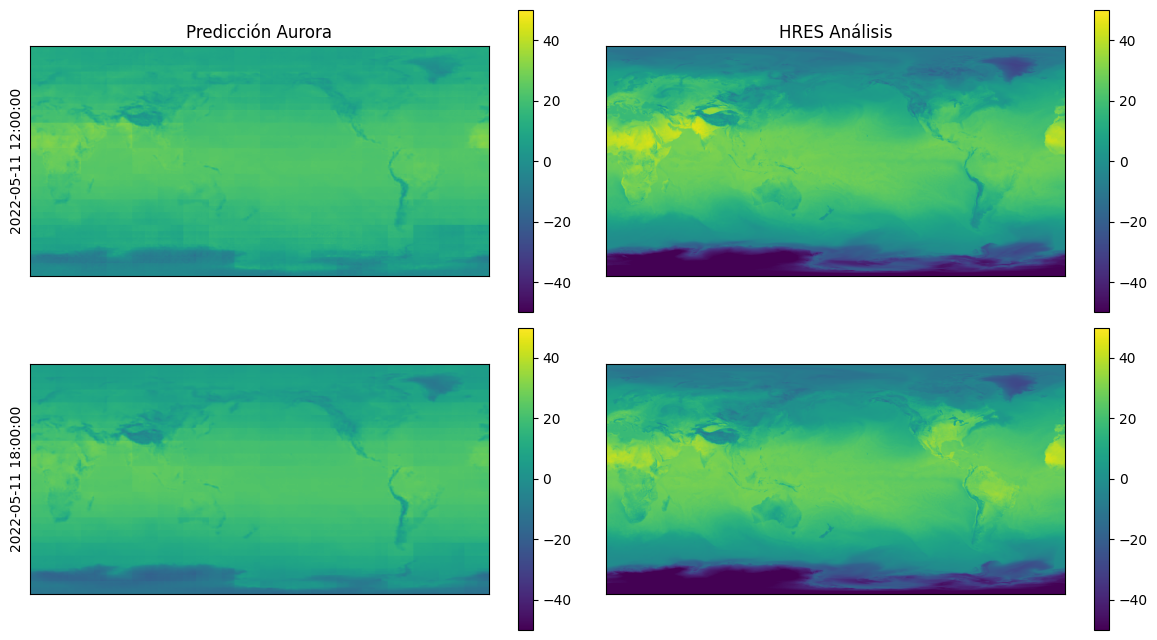

In [8]:
# Cargar datos reales para comparación
truth = xr.open_dataset(download_path / date.strftime("surf_2t_%Y-%m-%d.grib"), engine="cfgrib")

# Visualizar predicciones y datos reales
fig, ax = plt.subplots(2, 2, figsize=(12, 6.5))

for i in range(ax.shape[0]):
    pred = preds[i]

    # Predicción del modelo
    im_pred = ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50)
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Predicción Aurora")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    fig.colorbar(im_pred, ax=ax[i, 0], orientation="vertical")

    # Datos reales
    ref = truth["t2m"][2 + i].values - 273.15
    im_truth = ax[i, 1].imshow(ref, vmin=-50, vmax=50)
    if i == 0:
        ax[i, 1].set_title("HRES Análisis")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    fig.colorbar(im_truth, ax=ax[i, 1], orientation="vertical")

plt.tight_layout()
plt.show()


**Resultado:**
- Las predicciones muestran una mejor coherencia con los datos reales.
- Se observa una reducción en la sobreestimación de temperatura.
- Los artefactos (cuadrículas visibles) en las predicciones globales se han minimizado.


## Conclusión

En este test, al integrar correctamente nuestros datos (incluyendo la conversión de temperatura a Kelvin) y ajustar adecuadamente la resolución, hemos mejorado significativamente la inferencia de batches. Esto ha resultado en una reducción de la sobreestimación de temperatura y una minimización de artefactos en las predicciones globales del modelo Aurora.

Estos resultados demuestran la importancia de preprocesar correctamente los datos y de adaptar el lote a las expectativas del modelo. Con estas mejoras, el modelo proporciona predicciones más precisas y visualmente coherentes con los datos reales.
